# MMAI 2025 869: Team Project Template
*Updated May 3, 2024*

This notebook serves as a template for the Team Project. Teams can use this notebook as a starting point, and update it successively with new ideas and techniques to improve their model results.

Note that is not required to use this template. Teams may also alter this template in any way they see fit.

### Day 10 - hyperparameter tuning via Optuna


# Preliminaries: Inspect and Set up environment

No action is required on your part in this section. These cells print out helpful information about the environment, just in case.

In [69]:
import datetime
import pandas as pd
import numpy as np

In [70]:
print(datetime.datetime.now())

2024-05-29 20:25:41.984919


In [71]:
!which python

/Users/mhoy/.pyenv/versions/3.11.8/bin/python


In [72]:
!python --version

Python 3.11.8


In [73]:
!echo $PYTHONPATH

In [74]:
! pip install --user xgboost
! pip install --user fancyimpute
! pip install --user sklearn-genetic
! pip install --user ipywidgets
! pip install --user optuna

# 0. Data Loading and Inspection

## 0.1: Load data

The file containing the labeled training data is conveniently located on the cloud at the address below. Let's load it up and take a look.

In [75]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1eYCKuqJda4bpzXBVnqXylg0qQwvpUuum")
target_feature = 'h1n1_vaccine'

## 0.1 Simple Exploratory Data Analysis

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21365 entries, 0 to 21364
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 21292 non-null  float64
 1   h1n1_knowledge               21274 non-null  float64
 2   behavioral_antiviral_meds    21306 non-null  float64
 3   behavioral_avoidance         21202 non-null  float64
 4   behavioral_face_mask         21351 non-null  float64
 5   behavioral_wash_hands        21329 non-null  float64
 6   behavioral_large_gatherings  21293 non-null  float64
 7   behavioral_outside_home      21306 non-null  float64
 8   behavioral_touch_face        21263 non-null  float64
 9   doctor_recc_h1n1             19629 non-null  float64
 10  doctor_recc_seasonal         19629 non-null  float64
 11  chronic_med_condition        20594 non-null  float64
 12  child_under_6_months         20710 non-null  float64
 13  health_worker   

In [77]:
# Let's print some descriptive statistics for all the numeric features.

df.describe().T


,count,mean,std,min,25%,50%,75%,max
h1n1_concern,21292.0,1.618026,0.909311,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,21274.0,1.265018,0.617816,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,21306.0,0.049329,0.216559,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,21202.0,0.724507,0.446773,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,21351.0,0.070348,0.255739,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,21329.0,0.823574,0.381192,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,21293.0,0.357864,0.479383,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,21306.0,0.337464,0.472856,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,21263.0,0.675728,0.468113,0.0,0.0,1.0,1.0,1.0
doctor_recc_h1n1,19629.0,0.221662,0.415375,0.0,0.0,0.0,0.0,1.0


In [78]:
# What is the number of unique values in all the categorical features? And what is
# the value with the highest frequency?

df.describe(include=object).T

,count,unique,top,freq
age_group,21365,5,65+ Years,5454
education,20240,4,College Graduate,8063
race,21365,4,White,16974
sex,21365,2,Female,12748
income_poverty,17851,3,"<= $75,000, Above Poverty",10301
marital_status,20245,2,Married,10880
rent_or_own,19737,2,Own,15012
employment_status,20203,3,Employed,10886
hhs_geo_region,21365,10,lzgpxyit,3406
census_msa,21365,3,"MSA, Not Principle City",9268


In [79]:
# How much missing data is in each feature?

df.isna().sum()

h1n1_concern                      73
h1n1_knowledge                    91
behavioral_antiviral_meds         59
behavioral_avoidance             163
behavioral_face_mask              14
behavioral_wash_hands             36
behavioral_large_gatherings       72
behavioral_outside_home           59
behavioral_touch_face            102
doctor_recc_h1n1                1736
doctor_recc_seasonal            1736
chronic_med_condition            771
child_under_6_months             655
health_worker                    643
health_insurance                9858
opinion_h1n1_vacc_effective      318
opinion_h1n1_risk                311
opinion_h1n1_sick_from_vacc      321
opinion_seas_vacc_effective      371
opinion_seas_risk                410
opinion_seas_sick_from_vacc      431
age_group                          0
education                       1125
race                               0
sex                                0
income_poverty                  3514
marital_status                  1120
r

### Taking a look at the class imbalance of our target

No vaccine: 16821
Has vaccine: 4544
training_data_pos_scale_weight: 3.7018045774647885


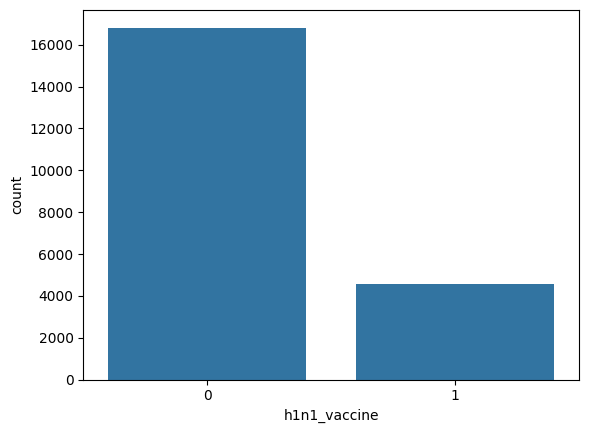

In [80]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

def get_target_skew_rate(data_target):
    target_df = pd.DataFrame(data_target)
    sns.countplot(x=target_feature, data=target_df)

    no_vaccine_count = len(target_df[target_df[target_feature]==0])
    yes_vaccine_count = len(target_df[target_df[target_feature]==1])
    print(f"No vaccine: {no_vaccine_count}")
    print(f"Has vaccine: {yes_vaccine_count}")

    # save this for later...
    training_data_pos_scale_weight = (no_vaccine_count / yes_vaccine_count)
    print(f"training_data_pos_scale_weight: {training_data_pos_scale_weight}")
    return training_data_pos_scale_weight

training_data_pos_scale_weight = get_target_skew_rate(df[target_feature])

In [81]:
# For convienience, let's save the names of all numeric features to a list,
# and the names of all categorical features to another list.

numeric_features = [
          "h1n1_concern",
          "h1n1_knowledge",
          "behavioral_antiviral_meds",
          "behavioral_avoidance",
          "behavioral_face_mask",
          "behavioral_wash_hands",
          "behavioral_large_gatherings",
          "behavioral_outside_home",
          "behavioral_touch_face",
          "doctor_recc_h1n1",
          "doctor_recc_seasonal",
          "chronic_med_condition",
          "child_under_6_months",
          "health_worker",
          "health_insurance",
          "opinion_h1n1_vacc_effective",
          "opinion_h1n1_risk",
          "opinion_h1n1_sick_from_vacc",
          "opinion_seas_vacc_effective",
          "opinion_seas_risk",
          "opinion_seas_sick_from_vacc",
          "household_adults",
          "household_children",
]

behavioural_features = list(x for x in numeric_features if 'behavioral' in x)

categorical_features = [
    "age_group",
    "education",
    "race",
    "sex",
    "income_poverty",
    "marital_status",
    "rent_or_own",
    "employment_status",
    "hhs_geo_region",
    "census_msa",
    "employment_industry",
    "employment_occupation",
]

all_features = numeric_features + categorical_features

all_cat_features = categorical_features

continuous_features = [
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
]

### helper method for getting the least correlated items to the target

In [82]:
def get_low_correlations_for_target(data, show_plot = False):
    corr = data.corr()

    threshold = 0.01
    tf_corr = corr[(abs(corr[target_feature]) <= threshold)]
    display(tf_corr)

    if show_plot:
        g = sns.heatmap(corr,  vmax=.3, center=0,
                    square=True, linewidths=1, 
                    cbar_kws={"shrink": .5}, annot=True, 
                    fmt='.2f', cmap='coolwarm')
        sns.despine()
        g.figure.set_size_inches(30,25)
        plt.show()

    return list(tf_corr.index)

## How do each of the behavioural features correlate to the target?

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,h1n1_vaccine


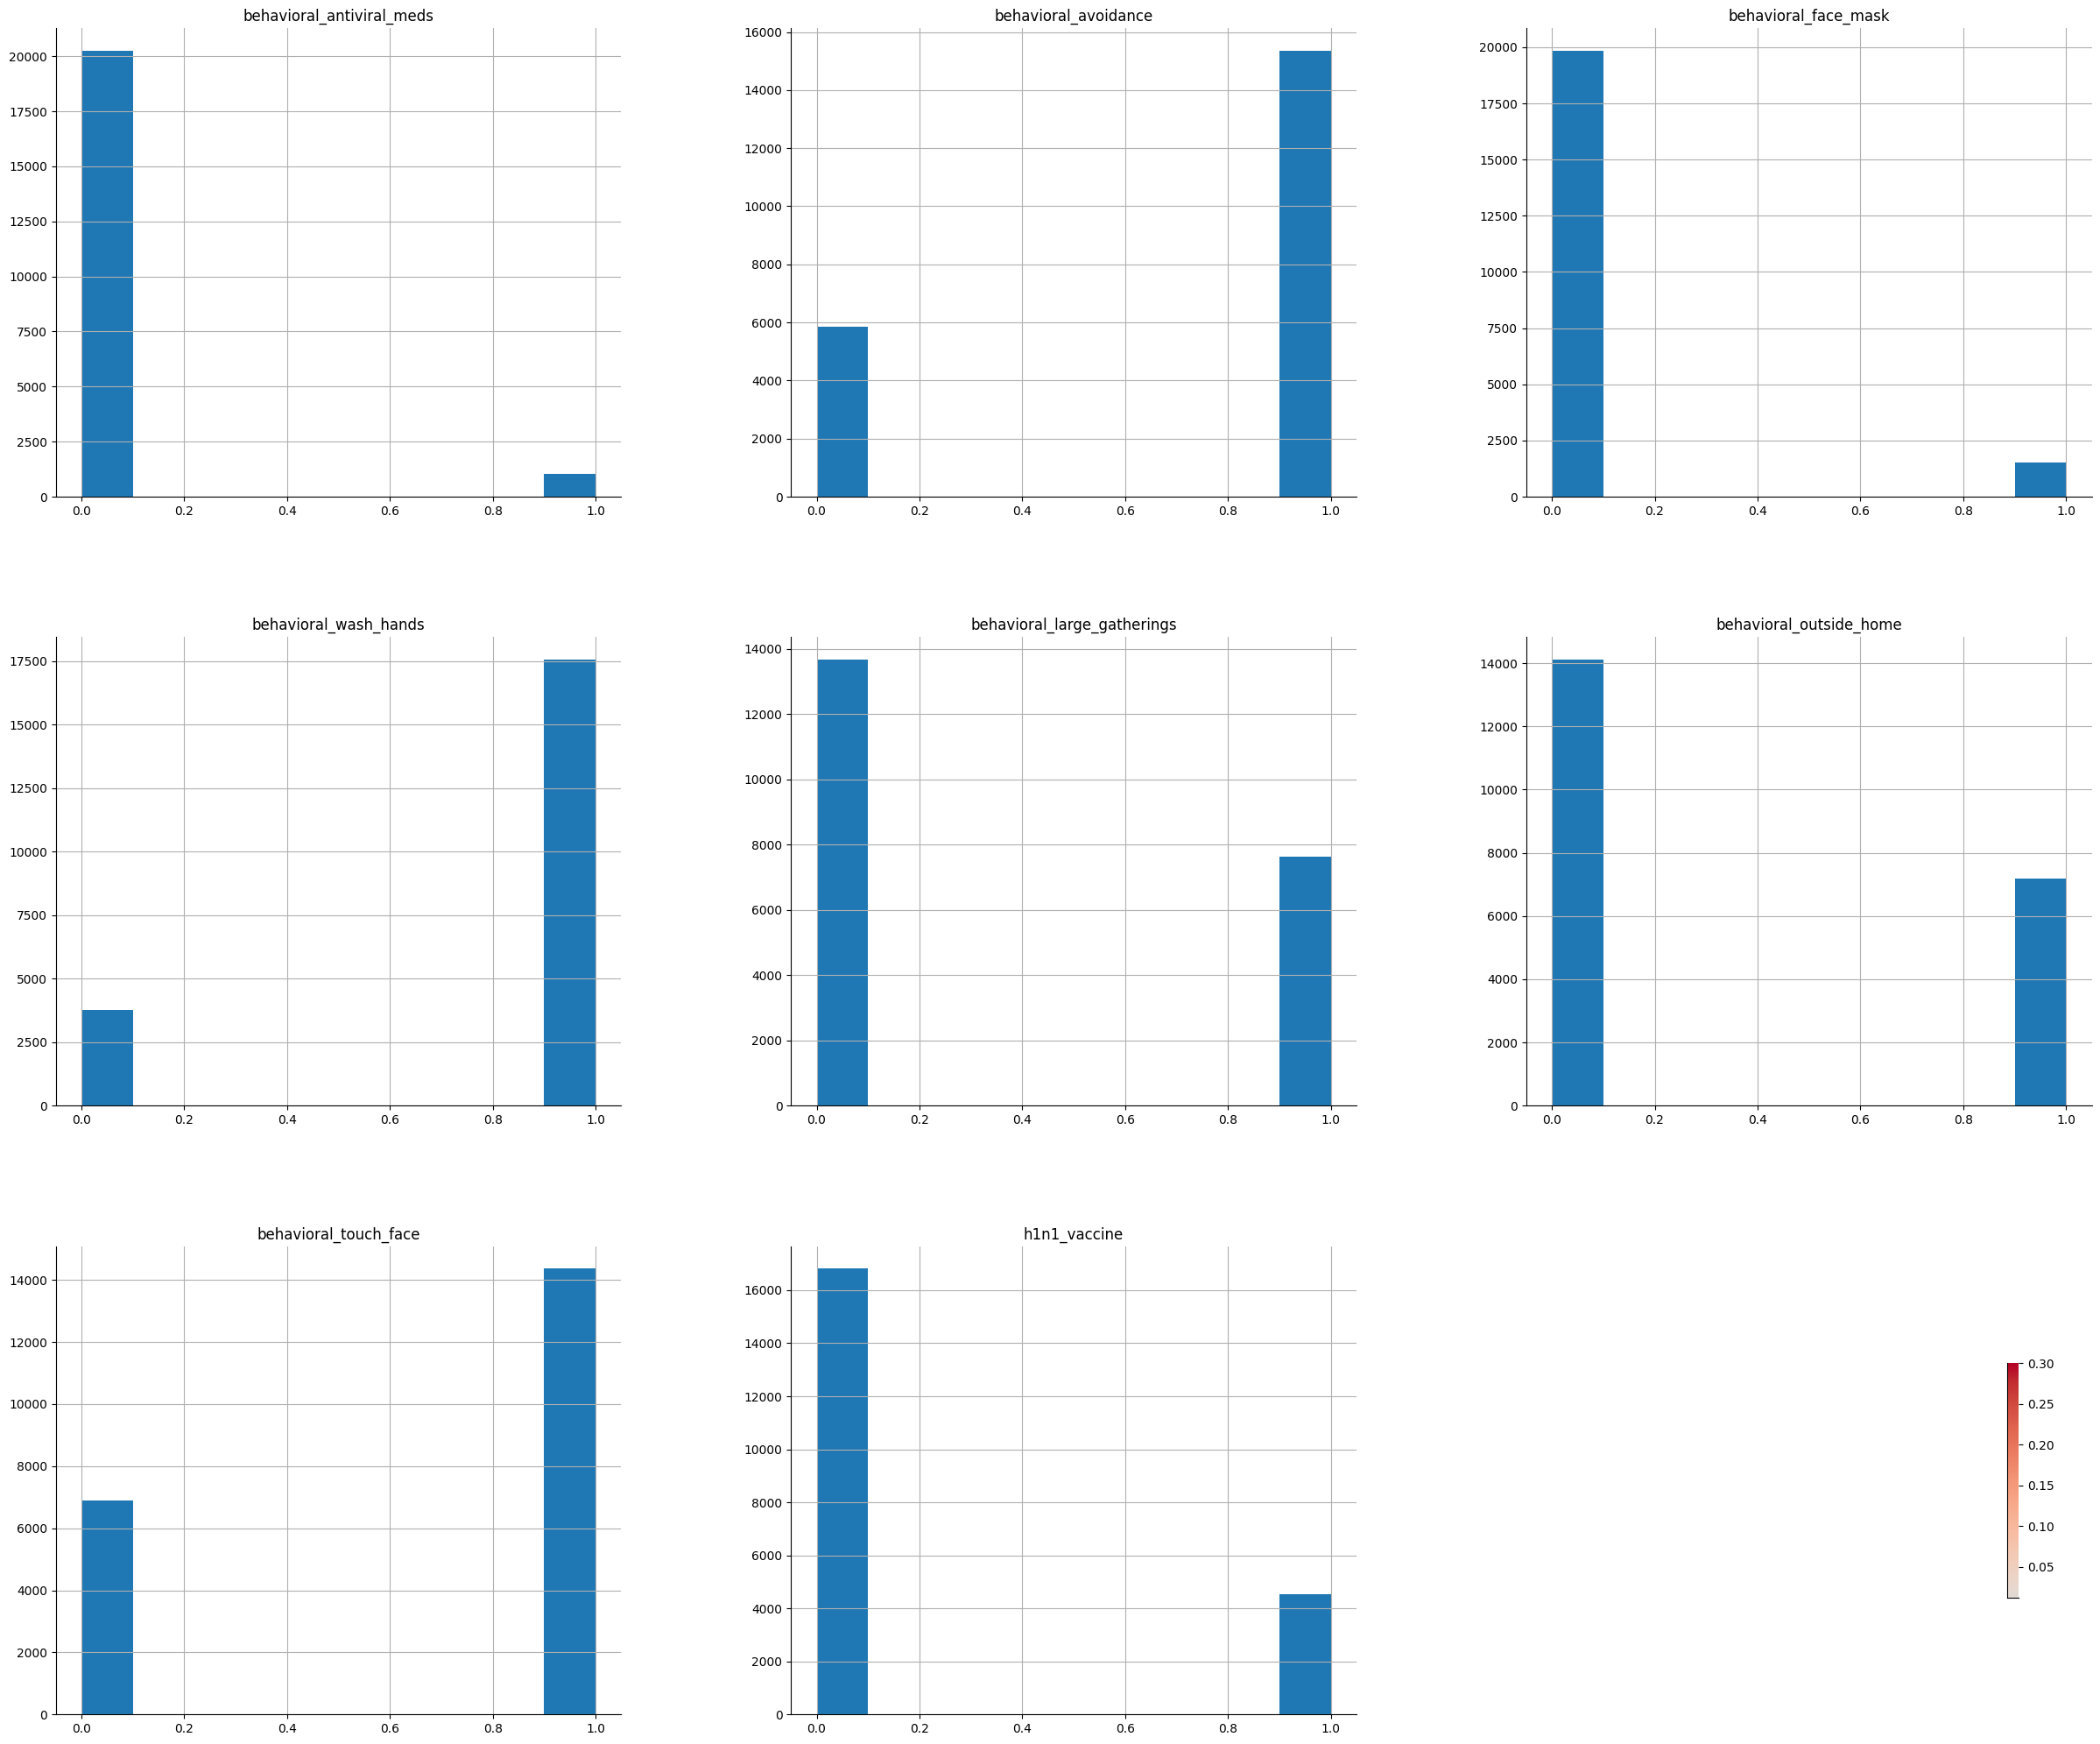

In [83]:
df_bv_target = pd.concat((df[behavioural_features], df[target_feature]), axis=1)
df_bv_target.hist()
get_low_correlations_for_target(df_bv_target, show_plot=True)

# separate these by skewedness in correlation with the target
# so when we FE combine these, it makes sense
behavioural_features_neg = [
          "behavioral_avoidance",
          "behavioral_wash_hands",
          "behavioral_outside_home",
          "behavioral_touch_face",
]

behavioural_features_pos = [x for x in behavioural_features if x not in behavioural_features_neg]


# 1. Train/Test Split

Now we randomly split the available data into train and test subsets.

The training data will later be used to build and assess the model on various combinations of hyperparaters.

The testing data will be used as a "final estimate" of a model's performance.

# 2. Model 1 (A simple DecisionTree model)

As a baseline, we'll do the absolute bare minimum data cleaning and then quickly build a simple Decision Tree.

In [84]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
# from sklearn.model_selection import train_test_split
import xgboost as xgb


In [85]:
# Scikit-learn needs us to put the features in one dataframe, and the label in another.
# It's tradition to name these variables X and y, but it doesn't really matter.

X = df.drop(target_feature, axis=1)
y = df[target_feature]

# X[continuous_features].hist()
#X[behavioural_features].hist()

## 1.1 Cleaning and FE

### Feature Encoding / Label Mapping

In [86]:
label_mapping = {}

def apply_label_mapping_fxn(row):
    global label_mapping
    for feature in all_cat_features:
        feature_mapping = label_mapping[feature]
        enc_value = feature_mapping[row[feature]]
        row[feature] = enc_value
    return row

def apply_label_mapping(data):
    return data.apply(apply_label_mapping_fxn, axis=1)

def update_row_mappings(row):
    global label_mapping
    for feature in all_cat_features:
        if not feature in label_mapping:
            label_mapping[feature] = {}
        enc_feature_name = f"{feature}_enc"
        orig_value = row[feature]
        enc_value = row[enc_feature_name]
        label_mapping[feature][orig_value] = enc_value

    return row

def set_label_mapping(orig_data, encoded_data):
    global label_mapping
    map_df = pd.DataFrame()
    for feature in all_cat_features:
        map_df[feature] = orig_data[feature]
        map_df[f"{feature}_enc"] = encoded_data[feature]
    map_df.apply(update_row_mappings, axis=1)

def label_encoding(data):
    global labeled_columns

    import category_encoders as ce
    encoder = ce.JamesSteinEncoder(cols=all_cat_features)
    labeled = encoder.fit_transform(data, y)
    labeled_columns = list(encoder.get_feature_names_out())

    set_label_mapping(data, labeled)

    return labeled


### Imputation

In [87]:
from fancyimpute import SoftImpute

def impute_data(data):
    return pd.DataFrame(SoftImpute(verbose=False).fit_transform(data), columns=data.columns)



### Scale our skewed features (using Box-Cox)

In [88]:
from sklearn.preprocessing import PowerTransformer
display(X[continuous_features].describe().T)

def set_non_zero(row):
    for feature in continuous_features:
        if row[feature] == 0.0:
            row[feature] = 0.00000001
    return row

def set_continuous_features(data):
    # data[continuous_features] = data[continuous_features].apply(set_non_zero, axis=1)

    display(data[continuous_features].describe().T)

    scaler = PowerTransformer(method='yeo-johnson')
    scaler.fit(data[continuous_features])
    data[continuous_features] = scaler.transform(data[continuous_features])
    # data[continuous_features].hist()
    return data

,count,mean,std,min,25%,50%,75%,max
opinion_h1n1_vacc_effective,21047.0,3.848910,1.008976,1.0,3.0,4.0,5.0,5.0
opinion_h1n1_risk,21054.0,2.345730,1.287865,1.0,1.0,2.0,4.0,5.0
opinion_h1n1_sick_from_vacc,21044.0,2.361196,1.362904,1.0,1.0,2.0,4.0,5.0
opinion_seas_vacc_effective,20994.0,4.029532,1.082279,1.0,4.0,4.0,5.0,5.0
opinion_seas_risk,20955.0,2.722023,1.385780,1.0,2.0,2.0,4.0,5.0
opinion_seas_sick_from_vacc,20934.0,2.121286,1.335174,1.0,1.0,2.0,4.0,5.0


### Feature Engineering

In [89]:
def feature_engineering(data):
    data['insured_family_size'] = data['household_adults'] + data['health_insurance'] + data['household_children']
    data['at_risk_patient'] = data['doctor_recc_h1n1'] + data['doctor_recc_seasonal'] + data['chronic_med_condition']

    data['behavioral_risk_neg'] = data[behavioural_features_neg].sum(axis=1)
    data['behavioral_risk_pos'] = data[behavioural_features_pos].sum(axis=1)
    # data = data.drop(behavioural_features, axis=1)

    data['opinion_seas_risk'] = data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']
    data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['h1n1_concern']
    data['poverty_vs_insurance'] = data['income_poverty'] + data['health_insurance']
    return data


## Correlation mapping...



### Drop the features that have a low correlation with the target

In [90]:
# this was gathered from using GAFeatureSelectionCV below after the final model

ga_feature_use = (('h1n1_concern', True),
 ('h1n1_knowledge', True),
 ('behavioral_antiviral_meds', False),
 ('behavioral_avoidance', True),
 ('behavioral_face_mask', False),
 ('behavioral_wash_hands', True),
 ('behavioral_large_gatherings', True),
 ('behavioral_outside_home', True),
 ('behavioral_touch_face', True),
 ('doctor_recc_h1n1', True),
 ('doctor_recc_seasonal', True),
 ('chronic_med_condition', False),
 ('child_under_6_months', True),
 ('health_worker', True),
 ('health_insurance', True),
 ('opinion_h1n1_vacc_effective', True),
 ('opinion_h1n1_risk', True),
 ('opinion_h1n1_sick_from_vacc', True),
 ('opinion_seas_vacc_effective', True),
 ('opinion_seas_risk', True),
 ('opinion_seas_sick_from_vacc', True),
 ('age_group', True),
 ('education', True),
 ('race', True),
 ('sex', False),
 ('income_poverty', False),
 ('marital_status', False),
 ('rent_or_own', True),
 ('employment_status', False),
 ('hhs_geo_region', True),
 ('census_msa', False),
 ('household_adults', False),
 ('household_children', True),
 ('employment_industry', True),
 ('employment_occupation', True))


def drop_not_used_ga_features(ret):
    features_to_drop = []
    for feature in ga_feature_use:
        if not feature[1]:
            features_to_drop.append(feature[0])
    display(f'Dropping: {features_to_drop}')
    return ret.drop(features_to_drop, axis=1)


In [91]:
heatmap_data = pd.concat([label_encoding(X), y], axis=1)
low_correlation_features = get_low_correlations_for_target(heatmap_data)

def clean_data(data, use_fe=False):
    ret = data
    
    ret = apply_label_mapping(ret)

    ret = impute_data(ret)
    ret = set_continuous_features(ret)

    if use_fe:
        ret = feature_engineering(ret)

    # ret = drop_not_used_ga_features(ret)

    # use our full training set to get the correlation data
    # ret = ret.drop(low_correlation_features, axis=1)

    return ret

cleaned_data = clean_data(X)
cleaned_data_fe = clean_data(X, use_fe = True)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
opinion_seas_sick_from_vacc,0.222891,-0.064476,0.084385,0.078971,0.101353,0.092033,0.135759,0.137775,0.092923,0.055074,...,-0.028392,-0.089694,-0.040087,-0.030540,-0.004128,0.019630,0.054649,-0.008723,-0.021985,0.000225
census_msa,-0.004295,0.052737,0.008361,0.007260,0.018310,0.004913,-0.052667,-0.041904,-0.022556,0.013221,...,-0.052605,-0.082343,-0.029317,-0.051005,1.000000,-0.002273,0.018309,0.011184,0.018651,0.005751
household_children,0.048426,0.050386,0.087459,0.038914,0.007088,0.049134,-0.012202,-0.014424,0.020550,0.033586,...,0.162315,-0.033011,-0.076230,0.015233,0.018309,0.187856,1.000000,0.017251,0.018737,-0.005867


,count,mean,std,min,25%,50%,75%,max
opinion_h1n1_vacc_effective,21365.0,3.824442,1.024825,0.560828,3.0,4.0,5.000000,5.0
opinion_h1n1_risk,21365.0,2.330693,1.285729,0.213785,1.0,2.0,4.000000,5.0
opinion_h1n1_sick_from_vacc,21365.0,2.346082,1.359361,0.245398,1.0,2.0,4.000000,5.0
opinion_seas_vacc_effective,21365.0,4.000288,1.099648,0.585813,4.0,4.0,5.000000,5.0
opinion_seas_risk,21365.0,2.701037,1.383165,0.258922,2.0,2.0,4.000000,5.0
opinion_seas_sick_from_vacc,21365.0,2.104664,1.328436,0.269741,1.0,2.0,2.664399,5.0


,count,mean,std,min,25%,50%,75%,max
opinion_h1n1_vacc_effective,21365.0,3.824442,1.024825,0.560828,3.0,4.0,5.000000,5.0
opinion_h1n1_risk,21365.0,2.330693,1.285729,0.213785,1.0,2.0,4.000000,5.0
opinion_h1n1_sick_from_vacc,21365.0,2.346082,1.359361,0.245398,1.0,2.0,4.000000,5.0
opinion_seas_vacc_effective,21365.0,4.000288,1.099648,0.585813,4.0,4.0,5.000000,5.0
opinion_seas_risk,21365.0,2.701037,1.383165,0.258922,2.0,2.0,4.000000,5.0
opinion_seas_sick_from_vacc,21365.0,2.104664,1.328436,0.269741,1.0,2.0,2.664399,5.0


## 1.2 Model Creation, Hyperparameter Tuning, and Validation

In [92]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

def display_cv(classifier, data, truth):
    classifier.fit(data, truth)
    predicted = classifier.predict(data)

    # We use cross_validate to perform K-fold cross validation for us.
    cv_results = cross_validate(classifier, data, truth, cv=5, scoring="f1_macro")
    f1_score = np.mean(cv_results['test_score'])
    display(f"results f1: {f1_score}")

    print(classification_report(truth, predicted))
    print(f"auc: {roc_auc_score(truth, predicted)}")

    confusion_matrix = metrics.confusion_matrix(truth, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.show()    

### Testing with a DecisionTreeClassifier 

{'class_weight': 'balanced',
 'max_depth': 6,
 'min_samples_leaf': 9,
 'ccp_alpha': 0}

-- DecisionTreeClassifier using: {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 9, 'ccp_alpha': 0}


'results f1: 0.7207286139695477'

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     16821
           1       0.51      0.77      0.61      4544

    accuracy                           0.79     21365
   macro avg       0.72      0.79      0.74     21365
weighted avg       0.84      0.79      0.81     21365

auc: 0.7851615061258103


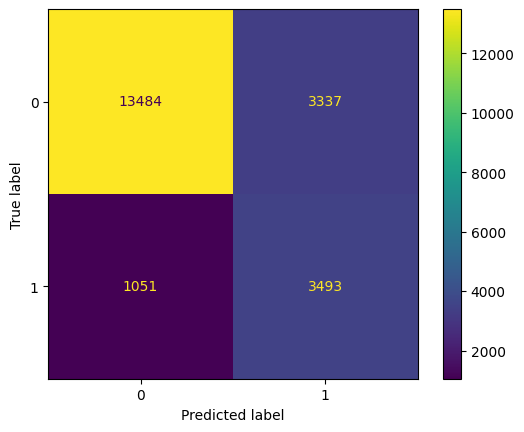

In [93]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


DO_DTC_TUNING = False

current_dt_params = {
    'class_weight': ['balanced'],
    'max_depth': [6], 
    'min_samples_leaf': [9],
    'ccp_alpha': [0]
}

def run_hypertune_test_dt(data, truth):
    search_params_to_use = {
    }
    
    test_model = DecisionTreeClassifier(random_state=1).fit(data, truth)
    grid_search_params = current_dt_params
    grid_search_params.update(search_params_to_use)

    # grid_search = RandomizedSearchCV(test_model, grid_search_params, n_iter=100, cv=5, n_jobs=-1, scoring="f1_macro")
    grid_search = GridSearchCV(test_model, grid_search_params, cv=5, n_jobs=-1, scoring="f1_macro")
    grid_search.fit(data, truth)
    display(grid_search.best_score_)
    best_params = grid_search.best_params_
    display(grid_search.best_params_)

    test_model = DecisionTreeClassifier(random_state=1, **best_params).fit(data, truth)
    display_cv(test_model, data, truth)
    return best_params

best_dt_params = {}
if DO_DTC_TUNING:
    best_dt_params = run_hypertune_test_dt(cleaned_data, y)
else:
    best_dt_params = { key: value[0] for key,value in current_dt_params.items()}
    

def get_dt_classifier(data, truth, parameters):
    print(f'-- DecisionTreeClassifier using: {parameters}')
    return DecisionTreeClassifier(random_state=1, **parameters).fit(data, truth)

display(best_dt_params)
test_c = get_dt_classifier(cleaned_data, y, best_dt_params)
display_cv(test_c, cleaned_data, y)


### Testing / Tuning with HistGradientBoostingClassifier 

In [94]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.callbacks import DeltaThreshold
from sklearn.model_selection import cross_val_score

import optuna

delta_callback = DeltaThreshold(threshold=0.0001, metric='fitness')

DO_HGB_TUNING = False

def optuna_objective_hgb(trial, data, truth):
    search_params_to_use = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 20, 100),
        'max_features': trial.suggest_float('max_features', 0.4, 1.0),
        'max_iter': trial.suggest_int('max_iter', 100, 300),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 2.0),
    }
    test_model = HistGradientBoostingClassifier(**search_params_to_use)

    cv_scores = cross_val_score(test_model, data, truth, cv=10, scoring='f1_macro')
    score = np.mean(cv_scores)
    return score


def run_hypertune_test_hgb(data, truth):
    # search_params_to_use = {
    #     'learning_rate': Continuous(0.1, 1.0, 'uniform', random_state=1),
    #     'class_weight': Categorical(choices=['balanced', None], random_state=1),
    #     'max_leaf_nodes': Integer(20, 100, 'uniform', random_state=1),
    #     'max_depth': Integer(20, 100, 'uniform', random_state=1),
    #     'max_features': Continuous(0.4, 1.0, 'uniform', random_state=1),
    #     'max_iter': Integer(100, 300, 'uniform'),
    #     'l2_regularization': Continuous(0.0, 2.0, 'uniform', random_state=1),
    # }

    # test_model = HistGradientBoostingClassifier(random_state=1).fit(data, truth)
    #grid_search = GASearchCV(test_model, param_grid=search_params_to_use, n_jobs=-1, scoring="f1_macro")
    #grid_search.fit(data, truth, callbacks=[delta_callback])
    # display(grid_search.best_score_)
    # best_params = grid_search.best_params_
    # display(grid_search.best_params_)
    # test_model = HistGradientBoostingClassifier(random_state=1, **best_params).fit(data.to_numpy(), truth.to_numpy())
    # display_cv(test_model, data, truth)

    ### OPTUNA TUNING ###
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: optuna_objective_hgb(trial, data, truth), n_trials=100,  gc_after_trial=True)
    best_params = study.best_params

    display(best_params)
    display(f'best_f1_score: {study.best_value}')
    display(f'best trial: {study.best_trial}')
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    return best_params

best_hgb_params = {}
if DO_HGB_TUNING:
    best_hgb_params = run_hypertune_test_hgb(cleaned_data, y)
else:
    best_hgb_params = {
        'learning_rate': 0.14381646994974304,
        'class_weight': None,
        'max_leaf_nodes': 60,
        'max_depth': 67,
        'max_features': 0.4661156289549712,
        'max_iter': 225,
        'l2_regularization': 1.8579441061914892
    }

def get_hgb_classifier(data, truth, params_to_use):
    print(f'-- HistGradientBoostingClassifier using: {params_to_use}')
    return HistGradientBoostingClassifier(random_state=1, **params_to_use).fit(data, truth)


[I 2024-05-29 20:26:00,792] A new study created in memory with name: no-name-c38edef1-a688-4945-9806-e5a0f098e8ff
[I 2024-05-29 20:26:02,674] Trial 0 finished with value: 0.7173594341316961 and parameters: {'learning_rate': 0.9850148004421526, 'class_weight': 'balanced', 'max_leaf_nodes': 78, 'max_depth': 97, 'max_features': 0.8666617703312304, 'max_iter': 162, 'l2_regularization': 0.7254695726625622}. Best is trial 0 with value: 0.7173594341316961.
[I 2024-05-29 20:26:03,930] Trial 1 finished with value: 0.7447987408059038 and parameters: {'learning_rate': 0.6175622254129268, 'class_weight': None, 'max_leaf_nodes': 40, 'max_depth': 40, 'max_features': 0.618319673345729, 'max_iter': 203, 'l2_regularization': 0.936778142838776}. Best is trial 1 with value: 0.7447987408059038.
[I 2024-05-29 20:26:06,515] Trial 2 finished with value: 0.7465605896279927 and parameters: {'learning_rate': 0.27517352046711924, 'class_weight': 'balanced', 'max_leaf_nodes': 57, 'max_depth': 34, 'max_features': 

{'learning_rate': 0.14381646994974304,
 'class_weight': None,
 'max_leaf_nodes': 60,
 'max_depth': 67,
 'max_features': 0.4661156289549712,
 'max_iter': 225,
 'l2_regularization': 1.8579441061914892}

'best_f1_score: 0.7579774966771209'

"best trial: FrozenTrial(number=93, state=1, values=[0.7579774966771209], datetime_start=datetime.datetime(2024, 5, 29, 20, 31, 33, 906291), datetime_complete=datetime.datetime(2024, 5, 29, 20, 31, 40, 423800), params={'learning_rate': 0.14381646994974304, 'class_weight': None, 'max_leaf_nodes': 60, 'max_depth': 67, 'max_features': 0.4661156289549712, 'max_iter': 225, 'l2_regularization': 1.8579441061914892}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'class_weight': CategoricalDistribution(choices=('balanced', None)), 'max_leaf_nodes': IntDistribution(high=100, log=False, low=20, step=1), 'max_depth': IntDistribution(high=100, log=False, low=20, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'max_iter': IntDistribution(high=300, log=False, low=100, step=1), 'l2_regularization': FloatDistribution(high=2.0, log=False, low=0.0, step=None)}, trial_

(optuna tuning)
```
'best_f1_score: 0.7570688530198766'

"best trial: FrozenTrial(number=57, state=1, values=[0.7570688530198766], datetime_start=datetime.datetime(2024, 5, 29, 19, 59, 35, 551291), datetime_complete=datetime.datetime(2024, 5, 29, 19, 59, 39, 970275), params={'learning_rate': 0.13808251235839147, 'class_weight': None, 'max_leaf_nodes': 49, 'max_depth': 62, 'max_features': 0.8203457955861235, 'max_iter': 300, 'l2_regularization': 1.930672765025027}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'class_weight': CategoricalDistribution(choices=('balanced', None)), 'max_leaf_nodes': IntDistribution(high=100, log=False, low=20, step=1), 'max_depth': IntDistribution(high=100, log=False, low=20, step=1), 'max_features': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'max_iter': IntDistribution(high=300, log=False, low=100, step=1), 'l2_regularization': FloatDistribution(high=2.0, log=False, low=0.0, step=None)}, trial_id=57, value=None)"
```

### Testing / Tuning with XGBoost

[I 2024-05-29 20:32:15,628] A new study created in memory with name: no-name-ca86f5cc-adc7-4b79-866b-a7856436e9c7
[I 2024-05-29 20:32:16,498] Trial 0 finished with value: 0.7581033060351189 and parameters: {'objective': 'binary:logistic', 'scale_pos_weight': 2.712936241821272, 'min_child_weight': 2.15786044531088, 'learning_rate': 0.13761334167020495, 'max_depth': 3, 'subsample': 0.9322456939371624, 'colsample_bytree': 0.7622256503850279, 'colsample_bylevel': 0.8581272764177345, 'colsample_bynode': 0.397368858902162, 'lambda': 1.3730445101167512, 'alpha': 1.3314125315695202, 'gamma': 0.06435297062830109, 'n_estimators': 102}. Best is trial 0 with value: 0.7581033060351189.
[I 2024-05-29 20:32:17,751] Trial 1 finished with value: 0.739882532849054 and parameters: {'objective': 'binary:logistic', 'scale_pos_weight': 3.0674256497487193, 'min_child_weight': 1.4638134208194222, 'learning_rate': 0.15041183707653855, 'max_depth': 2, 'subsample': 0.9082697758729035, 'colsample_bytree': 0.60104

{'objective': 'binary:logitraw',
 'scale_pos_weight': 2.9360556703403695,
 'min_child_weight': 2.479593590655206,
 'learning_rate': 0.11750014772021783,
 'max_depth': 3,
 'subsample': 0.9526655779292016,
 'colsample_bytree': 0.7043007123486567,
 'colsample_bylevel': 0.3083426556873394,
 'colsample_bynode': 0.6342968499700148,
 'lambda': 1.0591492693539948,
 'alpha': 0.8322970023773659,
 'gamma': 0.825805122509714,
 'n_estimators': 377}

'best_f1_score: 0.7711642490799178'

"best trial: FrozenTrial(number=59, state=1, values=[0.7711642490799178], datetime_start=datetime.datetime(2024, 5, 29, 20, 34, 3, 471495), datetime_complete=datetime.datetime(2024, 5, 29, 20, 34, 6, 33768), params={'objective': 'binary:logitraw', 'scale_pos_weight': 2.9360556703403695, 'min_child_weight': 2.479593590655206, 'learning_rate': 0.11750014772021783, 'max_depth': 3, 'subsample': 0.9526655779292016, 'colsample_bytree': 0.7043007123486567, 'colsample_bylevel': 0.3083426556873394, 'colsample_bynode': 0.6342968499700148, 'lambda': 1.0591492693539948, 'alpha': 0.8322970023773659, 'gamma': 0.825805122509714, 'n_estimators': 377}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'objective': CategoricalDistribution(choices=('binary:logitraw', 'binary:logistic')), 'scale_pos_weight': FloatDistribution(high=4.5, log=False, low=2.0, step=None), 'min_child_weight': FloatDistribution(high=3.0, log=False, low=0.1, step=None), 'learning_rate': FloatDistribution(high

{'objective': 'binary:logitraw',
 'scale_pos_weight': 2.9360556703403695,
 'min_child_weight': 2.479593590655206,
 'learning_rate': 0.11750014772021783,
 'max_depth': 3,
 'subsample': 0.9526655779292016,
 'colsample_bytree': 0.7043007123486567,
 'colsample_bylevel': 0.3083426556873394,
 'colsample_bynode': 0.6342968499700148,
 'lambda': 1.0591492693539948,
 'alpha': 0.8322970023773659,
 'gamma': 0.825805122509714,
 'n_estimators': 377}

-- XGBoost using: {'objective': 'binary:logitraw', 'scale_pos_weight': 2.9360556703403695, 'min_child_weight': 2.479593590655206, 'learning_rate': 0.11750014772021783, 'max_depth': 3, 'subsample': 0.9526655779292016, 'colsample_bytree': 0.7043007123486567, 'colsample_bylevel': 0.3083426556873394, 'colsample_bynode': 0.6342968499700148, 'lambda': 1.0591492693539948, 'alpha': 0.8322970023773659, 'gamma': 0.825805122509714, 'n_estimators': 377}


'results f1: 0.7717142197302047'

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     16821
           1       0.67      0.66      0.66      4544

    accuracy                           0.86     21365
   macro avg       0.79      0.79      0.79     21365
weighted avg       0.86      0.86      0.86     21365

auc: 0.7856608675147011


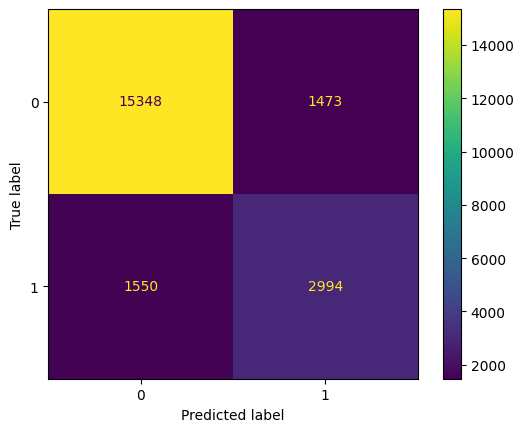

In [95]:
# do some testing...
DO_RUN_TUNING = False

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.callbacks import DeltaThreshold

delta_callback = DeltaThreshold(threshold=0.00005, metric='fitness')

def optuna_objective_xgboost(trial, data, truth):
    search_params_to_use = {
        'objective': trial.suggest_categorical('objective', ['binary:logitraw', 'binary:logistic']),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2.0, 4.5),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 3.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.08, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'subsample': trial.suggest_float('subsample', 0.9, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.0, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.0, 1.0),
        'lambda': trial.suggest_float('lambda', 0.5, 1.5),
        'alpha': trial.suggest_float('alpha', 0.0, 1.5),
        'gamma': trial.suggest_float('gamma', 0.0, 1.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    }    
    test_model = xgb.XGBClassifier(**search_params_to_use)

    cv_scores = cross_val_score(test_model, data, truth, cv=10, scoring='f1_macro')
    score = np.mean(cv_scores)
    return score

def run_hypertune_test(data, truth):

    # tuning process
    # 1. learning rate
    # 2. max_depth and min_child_weight
    # 3. gamma
    # 4. subsample and colsample_bytree
    # 5. then reduce the learning rate
    
    # search_params_to_use = {
    #     'objective': Categorical(['binary:logitraw', 'binary:logistic'], random_state=1),
    #     'scale_pos_weight': Continuous(2.0, 4.5, 'uniform', random_state=1),
    #     'min_child_weight': Continuous(0.1, 3.0, 'uniform', random_state=1),
    #     'learning_rate': Continuous(0.08, 0.3, 'uniform', random_state=1),
    #     'max_depth': Integer(2, 5, 'uniform', random_state=1),
    #     'subsample': Continuous(0.9, 1.0, 'uniform', random_state=1),
    #     'colsample_bytree': Continuous(0.0, 1.0, 'uniform', random_state=1),
    #     'colsample_bylevel': Continuous(0.0, 1.0, 'uniform', random_state=1),
    #     'colsample_bynode': Continuous(0.0, 1.0, 'uniform', random_state=1),
    #     'lambda': Continuous(0.5, 1.5, 'uniform', random_state=1),
    #     'alpha': Continuous(0.0, 1.5, 'uniform', random_state=1),
    #     'gamma': Continuous(0.0, 1.5, 'uniform', random_state=1),
    #     'n_estimators': Integer(50, 500, 'uniform', random_state=1),
    # }

    # test_model = xgb.XGBClassifier(random_state=1).fit(data.to_numpy(), truth.to_numpy())
    # grid_search = GASearchCV(test_model, param_grid=search_params_to_use, n_jobs=-1, scoring="f1_macro")    
    # grid_search.fit(data, truth, callbacks=[delta_callback])
    # display(grid_search.best_score_)
    # best_params = grid_search.best_params_
    # display(grid_search.best_params_)

    # test_model = xgb.XGBClassifier(random_state=1, **best_params).fit(data.to_numpy(), truth.to_numpy())
    # display_cv(test_model, data, truth)

    ### OPTUNA TUNING ###
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: optuna_objective_xgboost(trial, data, truth), n_trials=100,  gc_after_trial=True)
    best_params = study.best_params

    display(best_params)
    display(f'best_f1_score: {study.best_value}')
    display(f'best trial: {study.best_trial}')
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    return best_params

best_xgb_params = {}
if DO_RUN_TUNING:
    best_xgb_params = run_hypertune_test(cleaned_data, y)
else:
    best_xgb_params = {
        'objective': 'binary:logitraw',
        'scale_pos_weight': 2.9360556703403695,
        'min_child_weight': 2.479593590655206,
        'learning_rate': 0.11750014772021783,
        'max_depth': 3,
        'subsample': 0.9526655779292016,
        'colsample_bytree': 0.7043007123486567,
        'colsample_bylevel': 0.3083426556873394,
        'colsample_bynode': 0.6342968499700148,
        'lambda': 1.0591492693539948,
        'alpha': 0.8322970023773659,
        'gamma': 0.825805122509714,
        'n_estimators': 377
    }


def get_xgboost_classifier(data, truth, params_to_use = None):
    if params_to_use:
        final_params = params_to_use
    else:
        final_params = {
            # use this to help with the imbalanced targets
            'scale_pos_weight': training_data_pos_scale_weight,
            # it's a binary classifier - this method seems to work best
            'objective': 'binary:logitraw',
        }

    print(f'-- XGBoost using: {final_params}')

    return xgb.XGBClassifier(random_state=1, **final_params).fit(data, truth)

display(best_xgb_params)
test_c = get_xgboost_classifier(cleaned_data, y, best_xgb_params)
display_cv(test_c, cleaned_data, y)


(from optuna)

```
'best_f1_score: 0.7711642490799178'

"best trial: FrozenTrial(number=59, state=1, values=[0.7711642490799178], datetime_start=datetime.datetime(2024, 5, 29, 20, 34, 3, 471495), datetime_complete=datetime.datetime(2024, 5, 29, 20, 34, 6, 33768), params={'objective': 'binary:logitraw', 'scale_pos_weight': 2.9360556703403695, 'min_child_weight': 2.479593590655206, 'learning_rate': 0.11750014772021783, 'max_depth': 3, 'subsample': 0.9526655779292016, 'colsample_bytree': 0.7043007123486567, 'colsample_bylevel': 0.3083426556873394, 'colsample_bynode': 0.6342968499700148, 'lambda': 1.0591492693539948, 'alpha': 0.8322970023773659, 'gamma': 0.825805122509714, 'n_estimators': 377}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'objective': CategoricalDistribution(choices=('binary:logitraw', 'binary:logistic')), 'scale_pos_weight': FloatDistribution(high=4.5, log=False, low=2.0, step=None), 'min_child_weight': FloatDistribution(high=3.0, log=False, low=0.1, step=None), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.08, step=None), 'max_depth': IntDistribution(high=5, log=False, low=2, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.9, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'colsample_bynode': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'lambda': FloatDistribution(high=1.5, log=False, low=0.5, step=None), 'alpha': FloatDistribution(high=1.5, log=False, low=0.0, step=None), 'gamma': FloatDistribution(high=1.5, log=False, low=0.0, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=50, step=1)}, trial_id=59, value=None)"
```

-- XGBoost using: {'scale_pos_weight': 3.7018045774647885, 'objective': 'binary:logitraw'}


'results f1: 0.7589251891246894'

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     16821
           1       0.82      0.87      0.85      4544

    accuracy                           0.93     21365
   macro avg       0.89      0.91      0.90     21365
weighted avg       0.93      0.93      0.93     21365

auc: 0.9110355733548189


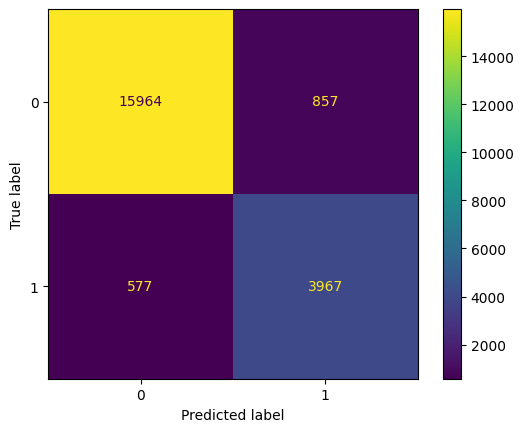

-- XGBoost using: {'objective': 'binary:logitraw', 'scale_pos_weight': 2.9360556703403695, 'min_child_weight': 2.479593590655206, 'learning_rate': 0.11750014772021783, 'max_depth': 3, 'subsample': 0.9526655779292016, 'colsample_bytree': 0.7043007123486567, 'colsample_bylevel': 0.3083426556873394, 'colsample_bynode': 0.6342968499700148, 'lambda': 1.0591492693539948, 'alpha': 0.8322970023773659, 'gamma': 0.825805122509714, 'n_estimators': 377}


'results f1: 0.7717142197302047'

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     16821
           1       0.67      0.66      0.66      4544

    accuracy                           0.86     21365
   macro avg       0.79      0.79      0.79     21365
weighted avg       0.86      0.86      0.86     21365

auc: 0.7856608675147011


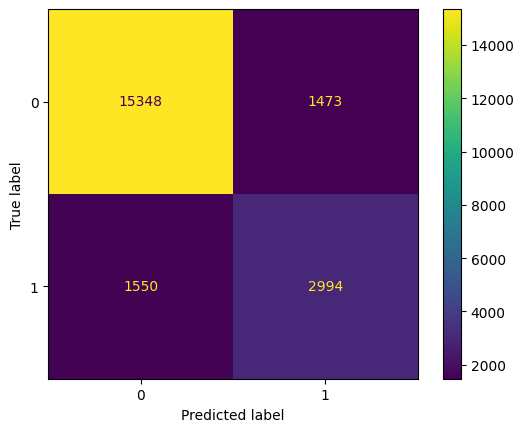

In [96]:
def run_xgboost(data, truth, params_to_use = None):
    clf = get_xgboost_classifier(data, truth, params_to_use)
    display_cv(clf, data, truth)

run_xgboost(cleaned_data, y)
#run_xgboost(cleaned_data_fe, y)
run_xgboost(cleaned_data, y, params_to_use = best_xgb_params )
#run_xgboost(cleaned_data_fe, y, params_to_use = best_xgb_params)

# note - current FE seems to do worse...


### Multiple classifiers

-- XGBoost using: {'objective': 'binary:logitraw', 'scale_pos_weight': 2.9360556703403695, 'min_child_weight': 2.479593590655206, 'learning_rate': 0.11750014772021783, 'max_depth': 3, 'subsample': 0.9526655779292016, 'colsample_bytree': 0.7043007123486567, 'colsample_bylevel': 0.3083426556873394, 'colsample_bynode': 0.6342968499700148, 'lambda': 1.0591492693539948, 'alpha': 0.8322970023773659, 'gamma': 0.825805122509714, 'n_estimators': 377}
-- HistGradientBoostingClassifier using: {'learning_rate': 0.14381646994974304, 'class_weight': None, 'max_leaf_nodes': 60, 'max_depth': 67, 'max_features': 0.4661156289549712, 'max_iter': 225, 'l2_regularization': 1.8579441061914892}


'results f1: 0.7700959797015476'

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     16821
           1       0.71      0.65      0.68      4544

    accuracy                           0.87     21365
   macro avg       0.81      0.79      0.80     21365
weighted avg       0.87      0.87      0.87     21365

auc: 0.7903620354042691


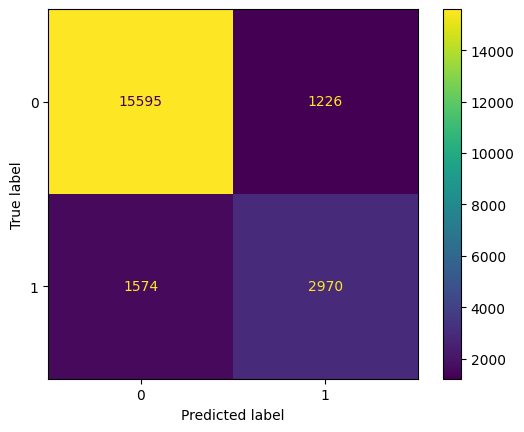

In [106]:
from sklearn.ensemble import VotingClassifier

def get_voting_classifier(data, truth):
    xgboost_tuned = get_xgboost_classifier(data, truth, best_xgb_params)
    hgb_tuned = get_hgb_classifier(data, truth, best_hgb_params)

    return VotingClassifier([
        # ('xgboost_base', xgboost_base),
        ('xgboost_tuned', xgboost_tuned),
        ('hgb_tuned', hgb_tuned),
    ], voting='soft').fit(data, truth)

def run_voting_classifier(data, truth):
    clf = get_voting_classifier(data, truth)
    display_cv(clf, data, truth)
    return clf

clf = run_voting_classifier(cleaned_data, y)


### Let's check our features with our final model - and see what we might want to tune out...

In [107]:
from sklearn_genetic.genetic_search import GAFeatureSelectionCV

if False:
    final_classifier = get_voting_classifier(cleaned_data, y)

    evolved_estimator = GAFeatureSelectionCV(
        estimator=clf,
        cv=5,
        scoring="accuracy",
        population_size=30,
        generations=20,
        n_jobs=-1,
        verbose=True,
        keep_top_k=2,
        elitism=True,
    )

    input_features = list(cleaned_data.columns)
    evolved_estimator.fit(cleaned_data, y)
    best_features = evolved_estimator.best_features_
    feature_mapping = zip(input_features, best_features)
    display(tuple(feature_mapping))
    
    from sklearn_genetic.plots import plot_fitness_evolution
    plot_fitness_evolution(evolved_estimator)
    plt.show()


## 1.4: Create Predictions for Competition Data

Once we are happy with the estimated performance of our model, we can move on to the final step.

First, we train our model one last time, using all available training data (unlike CV, which always uses a subset). This final training will give our model the best chance as the highest performance.

Then, we must load in the (unlabeled) competition data from the cloud and use our model to generate predictions for each instance in that data. We will then output those predictions to a CSV file. We will then send that file to Steve, and he can then tell us how well we did (because he knows the right answers!).

In [108]:
# Our model's "final form"

clf = clf.fit(clean_data(X), y)

,count,mean,std,min,25%,50%,75%,max
opinion_h1n1_vacc_effective,21365.0,3.824442,1.024825,0.560828,3.0,4.0,5.000000,5.0
opinion_h1n1_risk,21365.0,2.330693,1.285729,0.213785,1.0,2.0,4.000000,5.0
opinion_h1n1_sick_from_vacc,21365.0,2.346082,1.359361,0.245398,1.0,2.0,4.000000,5.0
opinion_seas_vacc_effective,21365.0,4.000288,1.099648,0.585813,4.0,4.0,5.000000,5.0
opinion_seas_risk,21365.0,2.701037,1.383165,0.258922,2.0,2.0,4.000000,5.0
opinion_seas_sick_from_vacc,21365.0,2.104664,1.328436,0.269741,1.0,2.0,2.664399,5.0


,count,mean,std,min,25%,50%,75%,max
opinion_h1n1_vacc_effective,5342.0,3.835746,1.014436,0.562064,3.0,4.0,5.000000,5.0
opinion_h1n1_risk,5342.0,2.317058,1.273009,0.212744,1.0,2.0,4.000000,5.0
opinion_h1n1_sick_from_vacc,5342.0,2.331147,1.358211,0.246755,1.0,2.0,4.000000,5.0
opinion_seas_vacc_effective,5342.0,3.985092,1.116701,0.564785,4.0,4.0,5.000000,5.0
opinion_seas_risk,5342.0,2.688049,1.378481,0.258697,2.0,2.0,4.000000,5.0
opinion_seas_sick_from_vacc,5342.0,2.089873,1.316965,0.254980,1.0,2.0,2.500559,5.0


No vaccine: 4474
Has vaccine: 868
training_data_pos_scale_weight: 5.154377880184332


'training target skew: 3.7018045774647885'

'predicted target skew: 5.154377880184332'

'difference: 1.4525733027195433'

,predicted
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,1


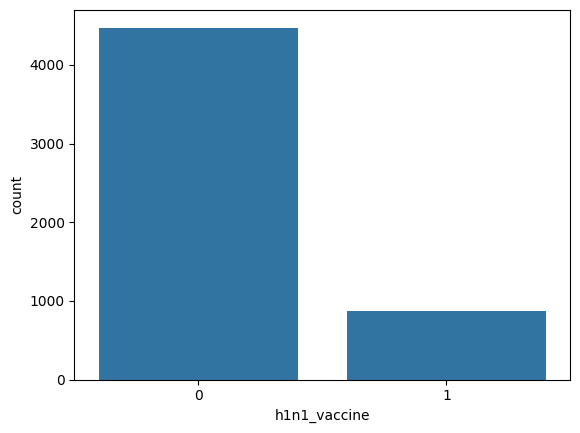

In [109]:
X_comp = pd.read_csv("https://drive.google.com/uc?export=download&id=1SmFBoNh7segI1Ky92mfeIe6TpscclMwQ")

# Importantly, we need to perform the same cleaning/transformation steps
# on this competition data as you did the training data. Otherwise, we will
# get an error and/or unexpected results.

X_comp = clean_data(X_comp)

# Use your model to make predictions
pred_comp = clf.predict(X_comp)

my_submission = pd.DataFrame({'predicted': pred_comp})

pred_data_pos_scale_weight = get_target_skew_rate(pd.DataFrame(pred_comp, columns=[target_feature]))

display(f'training target skew: {training_data_pos_scale_weight}')
display(f'predicted target skew: {pred_data_pos_scale_weight}')
display(f'difference: {abs(training_data_pos_scale_weight - pred_data_pos_scale_weight)}')

# Let's take a peak at the results (as a sanity check)
display(my_submission.head(10))

# You could use any filename.
my_submission.to_csv('my_submission.csv', index=False)

# You can now download the above file from Colab (see menu on the left)

# Model 2 (Your idea Here!)

Here, you can do all the above, but try different ideas:

- Different ML algorithms (e.g., RandomForestClassifier, LGBM, NN)
- Different data cleaning steps (Ordinal encoding, One Hot Encoding, etc.)
- Hyperparameter tuning (using, e.g., GridSearchCV or RandomizedSearchCV)
- Ensembles
- .... anything you can think of!


Steve's GitHub page is a great place for ideas:

https://github.com/stepthom/869_course

In [101]:
# TODO: Win the competition here!

# Model 3 (Your next idea here!)

In [102]:
# TODO: Win the competition here, too!